# Nonlinear Glucose Model Without Delay

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO
import pandas as pd
from scipy.interpolate import interp1d

In [5]:
# import data from Parsed.csv
df = pd.read_csv('Parsed.csv')
# df.describe()
df.head(20)

,Date,Time,Blood Glucose (mg/dL),Insulin Delivery (IU)
0,2021-02-28,00:00:00,NaN,0.024
1,2021-02-28,00:01:00,266.0,0.024
2,2021-02-28,00:02:00,NaN,0.024
3,2021-02-28,00:03:00,NaN,0.024
4,2021-02-28,00:04:00,NaN,0.024
5,2021-02-28,00:05:00,NaN,0.024
6,2021-02-28,00:06:00,274.0,0.024
7,2021-02-28,00:07:00,NaN,0.024
8,2021-02-28,00:08:00,NaN,0.024
9,2021-02-28,00:09:00,NaN,0.024


In [3]:
# # MHE/MPC Model using NlGM
# m = GEKKO()

# m.time = np.linspace(0, 180, 181) # Time horizon of 3 hours

# # FV

# # Const
# Kx = m.Const(0.01)  # (1/min) Rate of insulin dispered from injection site
# nT

# # Vars
# I = m.Var()  # Plasma Insulin
# Q = m.Var()  # Interstitial Insulin Concentration
# Ps = m.Var() # glucose absorbed into the gut
# Us = m.Var() # Subcutaneous glucose concentration
# Px = m.Var() # regular meals of varying glucose content ~450 mmol for each meal
# Pc = m.Var() # Snack Function - three snacks a day of 160 mmol
# ϵ = m.Var()  # exercise level
# SI = m.Var() # insulin sensitivity

# # MV
# Ux = m.MV()  # insulin infusion

# # CV
# G = m.CV()   # Blood Glucose Concentration (mg/dl)

# # Equations

# # Options

# Bergman Model

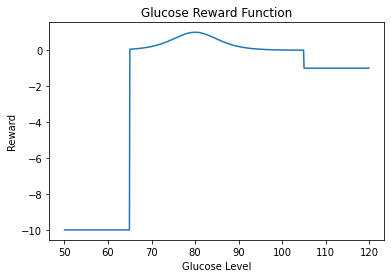

In [4]:
# Objective function variables
target = 80 # target
slope = 0.7
ub = 105     # upper bound
lb = 65    # lower bound
lm = 10     # lower penalty multiplier

glucose_ = np.linspace(0, 300, 3000)
reward = []
for g in glucose_:
    if g < lb:
        r = -1 * lm
    elif g > ub:
        r = -1
    else:
        r = 1.0 - np.tanh(np.abs((g - target) / slope) * .1) **2
    reward.append(r)
    
# plot reward function
plt.title('Glucose Reward Function')
plt.plot(glucose_[500:1200], reward[500:1200])
plt.xlabel('Glucose Level')
plt.ylabel('Reward')
plt.show()


reward_func = interp1d(glucose_, reward)

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime
import pandas as pd
from gekko import GEKKO
N = 24*60 #minutes in a day
df = pd.read_csv('Parsed.csv')
BG_dat = df['Blood Glucose (mg/dL)'].values[:N]
U_dat  = df['Insulin Delivery (IU) '].values[:N]
# BG = BG.dropna().values
for i in range(len(BG_dat)):
    if i==0:
        BG_dat[i] = BG_dat[i+1]
    elif np.isnan(BG_dat[i]):
        BG_dat[i] = BG_dat[i-1]
# For m in [mhe, sim]
#minutes run

m = GEKKO()

# TODO Find optimal control horizon to account for disturbances especially
m.time = np.linspace(0,N-1, N)  # Three hour moving horizon
dt=1
# Params
bg = m.Param(291.0, name='bg')  # (mg/dL) Basal Blood Glucose
p1 = m.Param(3.17e-2, name='p1')   # (1/min)
p2 = m.Param(1.23e-2, name='p2')   # (1/min)
# si = m.Param(2.9e-2)    # (1/min * (mL/micro-U))
ke = m.Param(9.0e-2, name='ke')    # (1/min) Insulin elimination from plasma
kabs = m.Param(1.2e-2, name='kabs')  # (1/min) t max,G inverse
kemp = m.Param(1.8e-1, name='kemp')  # (1/min) t max,I inverse
f = m.Param(8.00e-1, name='f')    # (L)
vi = m.Param(12.0, name='vi')      # (L)     Insulin distribution volume
vg = m.Param(12.0, name='vg')      # (L)     Glucose distibution volume

# final = np.zeros_like(m.time)
# final[-1] = 1
# fin = m.Param(final)

# FV
# TODO implement good bounds on these
# TODO Bounds on possible levels

si = m.FV(2.9e-2, lb=0.01, ub=1, name='si')    # (1/min * (mL/micro-U))
D  = m.MV(0, lb=0, ub=4000, name='D')      # Disturbance (mmol/L min)

# Vars
# TODO: Initial Values
G = m.CV(value=BG_dat,  lb=10, ub=400,name='G')    # (mg/dL) Blood Glucose
X = m.Var(1,name='X')      # (μu/ml) Remote Insulin
I = m.Var(1,name='I')      # (μu/ml) Plasma Insulin
U = m.MV(value=U_dat, lb=0,name='U')       # (mU/min) Insulin Delivery
GG = m.Var(1,name='GG')     # (mg/dL) Gut insulin

S1 = m.Var(name='S1')     # Subcutaneous storage
S2 = m.Var(name='S2')     # Intermediate 2

# obj = m.Var(0)

# Equations
m.Equations([
    G.dt() == -p1*(G-bg) - si*X*G + f*kabs/vg*GG+f/vg*D,  # Dynamic Insulin Rate
    X.dt() == p2*(I - X),                                                 # Remote Insulin dynamics
    I.dt() == -ke*I + U,                                                  # Plasma Insulin Concentration
    S1.dt() == U - kemp*S1,                                               # Dynamic Model
    S2.dt() == -kemp*(S2-S1),                                           # Dynamic Model
    GG.dt() == kemp*S2 - kabs*GG])
#     obj.dt() == m.if3(G-lb, -1 * lm, m.if3(ub-g, -1, 1.0 - m.tanh(m.abs3((G-target)/slope)*0.1)**2)) # m.integral(print(reward_func(G)[0]))


## Tuning
si.STATUS = 1; si.FSTATUS = 0
D.STATUS  = 1; D.FSTATUS  = 0
D.DCOST=.001


G.STATUS  = 1; G.FSTATUS  = 1
U.STATUS  = 0; U.FSTATUS  = 1

## Global options
m.options.IMODE   = 5
m.options.EV_TYPE = 2
try:
    m.solve(disp=False)    # solve
except:
    print('Not successful')
    from gekko.apm import get_file
    print(m._server)
    print(m._model_name)
    f = get_file(m._server,m._model_name,'gk_model0.apm')
    f = f.decode().replace('\r','')
    with open('gk_model0.apm', 'w') as fl:
        fl.write(str(f))

In [14]:
# For m in [mhe, sim]
dt = 5  # (min) timespacing
m = GEKKO()

# TODO Find optimal control horizon to account for disturbances especially
m.time = np.linspace(0, 180, 181)  # Three hour moving horizon

# Params
bg = m.Param(291.0, name='bg')  # (mg/dL) Basal Blood Glucose
p1 = m.Param(3.17e-2, name='p1')   # (1/min)
p2 = m.Param(1.23e-2, name='p2')   # (1/min)
si = m.Param(2.9e-2)    # (1/min * (mL/micro-U))
ke = m.Param(9.0e-2)    # (1/min) Insulin elimination from plasma
kabs = m.Param(1.2e-2)  # (1/min) t max,G inverse
kemp = m.Param(1.8e-1)  # (1/min) t max,I inverse
f = m.Param(8.00e-1)    # (L)
vi = m.Param(12.0)      # (L)     Insulin distribution volume
vg = m.Param(12.0)      # (L)     Glucose distibution volume

final = np.zeros_like(m.time)
final[-1] = 1
fin = m.Param(final)

# FV
# TODO implement good bounds on these
# TODO Bounds on possible levels

si = m.FV(2.9e-2)    # (1/min * (mL/micro-U))
D = m.FV(0, lb=0, ub=4000)      # Disturbance (mmol/L min)

# storage arrays
bg_ = np.zeros_like(m.time)
D_  = np.zeros_like(m.time)
G_  = np.zeros_like(m.time)

# Vars
# TODO: Initial Values
G = m.CV(266)    # (mg/dL) Blood Glucose
X = m.Var()      # (μu/ml) Remote Insulin
I = m.Var()      # (μu/ml) Plasma Insulin
U = m.MV()       # (mU/min) Insulin Delivery
GG = m.Var()     # (mg/dL) Gut insulin

S1 = m.Var()     # Intermediate 1
S2 = m.Var()     # Intermediate 2

# obj = m.Var(0)

# Equations
m.Equations([
    G.dt()/dt == -p1 * (G-bg) - si * X * G + f * kabs / vg * GG + f / vg * D,  # Dynamic Insulin Rate
    X.dt()/dt == p2 * (I - X),                                                 # Remote Insulin dynamics
    I.dt()/dt == -ke * I + U,                                                  # Plasma Insulin Concentration
    S1.dt()/dt == U - kemp * S1,                                               # Dynamic Model
    S2.dt()/dt == -kemp * (S2 - S1),                                           # Dynamic Model
    GG.dt()/dt == kemp * S2 - kabs * GG,
#     obj.dt() == m.if3(G-lb, -1 * lm, m.if3(ub-g, -1, 1.0 - m.tanh(m.abs3((G-target)/slope)*0.1)**2)) # m.integral(print(reward_func(G)[0]))
])

# Options
## Tuning
si.STATUS = 1; si.FSTATUS = 0
D.STATUS  = 1; D.FSTATUS  = 0

G.STATUS  = 1; G.FSTATUS  = 1
U.STATUS  = 0; U.FSTATUS  = 1

## Global options
m.options.IMODE   = 5
m.options.EV_TYPE = 1
m.options.SOLVER  = 3
m.options.MAX_ITER = 500

m.Maximize(obj * fin)

In [15]:
# iterate through rows and update with MPC
# TODO Can we use measurements every 5 minutes for one variable and every 5 for another?
# Drop rows with NaN
df_dense = df.dropna()
i=0
print(df_dense)
for date, time, glucose, insulin_delivery in df_dense.itertuples(index=False):
    print(f'iteration {i}'.center(30,'-')) 
    # only update glucose measurement if not NaN
    if not np.isnan(glucose):
        G.MEAS = glucose
    
    U.MEAS = insulin_delivery
    # solve with MHE
    m.solve(disp=True)
    
    # Store MHE values for basal glucose rate and disturbances
    print(f'{bg.NEWVAL=}')
    print(f'{D.NEWVAL=}')
    print(f'{G.MODEL}')
    bg_[i] = bg.NEWVAL
    D_[i]  = D.NEWVAL
    G_[i] = G.MODEL
    
    i += 1
        
    

             Date      Time  Blood Glucose (mg/dL)  Insulin Delivery (IU) 
1      2021-02-28  00:01:00                  266.0                   0.024
6      2021-02-28  00:06:00                  274.0                   0.024
11     2021-02-28  00:11:00                  277.0                   0.024
16     2021-02-28  00:16:00                  276.0                   0.024
21     2021-02-28  00:21:00                  276.0                   0.024
...           ...       ...                    ...                     ...
45621  2021-03-31  17:21:00                  227.0                   0.000
45626  2021-03-31  17:26:00                  226.0                   0.000
45631  2021-03-31  17:31:00                  228.0                   0.346
45636  2021-03-31  17:36:00                  226.0                   0.000
45641  2021-03-31  17:41:00                  219.0                   0.000

[8796 rows x 4 columns]
---------iteration 0----------
apm 66.90.216.18_gk_model4 <br><pre> -------

Exception:  @error: Model Expression
 *** Error in syntax of function string: Invalid element: v7
 
Position: 5                   
 -(((v7)*(p11)))
     ?



In [ ]:
# TODO analyze inputs and outputs to create ARX model

In [ ]:
# Control Based on ARX model & simulated disturbances
def get_situation(sim_interval=5):
    '''
    return parameters neccesary to simulate a day
    :param sim_interval: minutes per discretized interval'''
    # Meal data for disturbances
    # order:              [breakfast, snack1, lunch, snack2, dinner, snack3]
    meal_prob  = np.array([0.80     , 0.4   , 0.90 , 0.2   , 0.95  , 0.4   ])  # probability of having a meal
    meal_tm_lb = np.array([5        , 9     , 10   , 12    , 16    , 17    ])  # lower limit for time to have meal
    meal_tm_ub = np.array([9        , 12    , 15   , 17    , 20    , 23    ])  # upper limit to have meal
    meal_size  = np.array([2500     , 1250  , 2800 , 1250  , 2800  , 1250  ])/sim_interval  # normal meal size
    
    # probability stuff
    meal_score = np.random.rand(len(meal_prob))                                             # random number between 0 and 1 generated for each meal
    meal_occur = meal_prob > meal_score                                                     # Whether a meal will occur determined by random number
    meal_time = np.random.normal((meal_tm_lb + meal_tm_ub)/2, (meal_tm_ub - meal_tm_lb)/4)  # meal time is distributed normally with 95% between upper and lower bounds
    meal_size *= (np.random.rand(len(meal_prob))+0.5)                                       # meal size scaled by 0.5 to 1.5
    
    # scale time to sim_interval
    sim_points      = int(24 * 60 / sim_interval) + 1   # find number of discretized points
    meal_index      = int(meal_time * sim_points / 24)  # create indexes of meals
    sim_time        = np.linspace(0, 24, sim_points)    # add time array for simulation
    sim_disturbance = np.zeros_like(sim_time)           # create disturbance array (added glucose)
    sim_disturbance[meal_index-1] = meal_size * 0.3     # Spread meal over 3 time intervals
    sim_disturbance[meal_index]   = meal_size * 0.4
    sim_disturbance[meal_index+1] = meal_size * 0.3
    return sim_time, sim_disturbance

def sim_day():
    '''Simulate a day'''
    return
